# Working with the usbmd pipeline

In [1]:
# Set the working directory to the root of the repository
# We do this by moving up until we find the file .gitignore (which is in the
# root of the repository)
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

while not os.path.exists('pyproject.toml'):
    os.chdir('..')

In [2]:
import pprint
import matplotlib.pyplot as plt
import numpy as np

from usbmd import setup, Config
from usbmd.data import load_usbmd_file
from usbmd.display import to_8bit
from usbmd.ops import Pipeline, PatchedGrid, EnvelopeDetect, Normalize, LogCompress, TOFCorrection, PfieldWeighting, DelayAndSum, Demodulate
from usbmd.visualize import set_mpl_style

In [3]:
# choose your config file
# all necessary settings should be in the config file
config_path = "./configs/config_usbmd_carotid.yaml"

# setup function handles local data paths, default config settings and GPU usage
# make sure to create your own users.yaml using usbmd/datapaths.py
users_paths = "./users.yaml"
config = setup(config_path, users_paths, create_user=True)

# we now manually point to our data
data_root = config.data.user.data_root
user = config.data.user.username

print(f"\n🔔 Hi {user}! You are using data from {data_root}\n")

# dataset_folder: USBMD_datasets/2023_USBMD_carotid/HDF5
dataset_folder = config.data.dataset_folder

# file_path: 2_cross_bifur_right_0000.hdf5
file = config.data.file_path
data_path = data_root / dataset_folder / file

assert data_path.exists(), f"🚫 Data path does not exist: {data_path}, please check your paths"

set_mpl_style()

usbmd: Using config file: ./configs/config_usbmd_carotid.yaml
usbmd: Git branch and commit: feature/sphinx=9bcf048ddf7caee8c9a9521b743a48356baeba63
usbmd: Data paths set successfully.
usbmd: Here's a summary of your data paths:
	data_root: /mnt/z/Ultrasound-BMd/data
	repo_root: /ultrasound-toolbox/usbmd/datapaths.py
	output: /mnt/z/Ultrasound-BMd/pretrained
	system: linux
	username: devcontainer0
	hostname: f2dde1ea1a7d

-------------------GPU settings-------------------
     memory
GPU        
0      2566
1      2386
2     10852
3     10852
4     10852
5     10852
6     10852
7     10852
Selecting 1 GPU based on available memory.
Selected GPU 2 with Free Memory: 10852.00 MiB
Hiding GPUs [0, 1, 3, 4, 5, 6, 7] from the system.
--------------------------------------------------

🔔 Hi devcontainer0! You are using data from /mnt/z/Ultrasound-BMd/data



In [4]:
# only 1 frame is loaded for this example
selected_frames = [0]

# loading a file manually using `load_usbmd_file`
data, scan, probe = load_usbmd_file(
    data_path, frames=selected_frames, data_type="raw_data"
)

# index the first frame
data_frame = data[0]

# reduce number of transmits for faster processing
scan.selected_transmits = 11
data_frame = np.take(data_frame, scan.selected_transmits, axis=0)

usbmd: WARNING The probe geometry in the data file does not match the probe geometry of the probe. The probe geometry has been updated to match the data file.


In [5]:
# showing the current pipeline from config
# you can see we have a nested pipeline (PatchedGrid is also a pipeline)
pprint.pprint(config.pipeline)

<Config {'operations': [{'name': 'demodulate'}, {'name': 'patched_grid', 'params': {'operations': [{'name': 'tof_correction', 'params': {'apply_phase_rotation': True}}, {'name': 'pfield_weighting'}, {'name': 'delay_and_sum'}], 'num_patches': 100}}, {'name': 'envelope_detect'}, {'name': 'normalize'}, {'name': 'log_compress'}], 'jit_kwargs': None, 'name': 'pipeline', 'with_batch_dim': True, 'jit_options': 'ops', 'validate': True}>


usbmd: Loading cached result for compute_pfield.


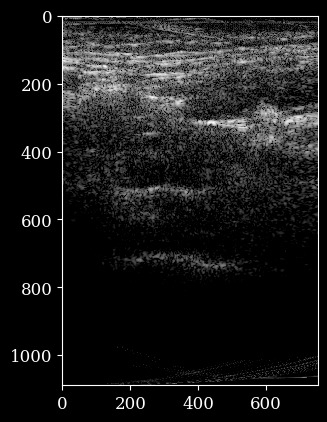

In [6]:
pipeline_config = Config({
    "operations": [
        {"name": "demodulate"},
        {
            "name": "patched_grid",
            "params": {
                "operations": [
                    {"name": "tof_correction"},
                    {"name": "pfield_weighting"},
                    {"name": "delay_and_sum"}
                ],
                "num_patches": 200,
            }
        },
        {"name": "envelope_detect"},
        {"name": "normalize"},
        # static parameters always go in init of the Operations, which can also be
        # defined here in the config (if not defaults are used)
        {"name": "log_compress", "params": {"key": "data", "output_key": "image"}}
    ]
}
)
# pipeline = Pipeline.from_config(pipeline_config, with_batch_dim=False, jit_options="pipeline")
pipeline = Pipeline.from_default(num_patches=100, with_batch_dim=False, jit_options="pipeline")

parameters = pipeline.prepare_parameters(probe, scan, config)

inputs = {pipeline.key: data_frame}


# dynamic parameters can be freely passed here as keyword arguments
outputs = pipeline(**inputs, **parameters)

image = outputs[pipeline.output_key]

image_display = to_8bit(image, config.data.dynamic_range)

plt.figure()
plt.imshow(image_display, cmap="gray")
plt.savefig("after_demod.png")


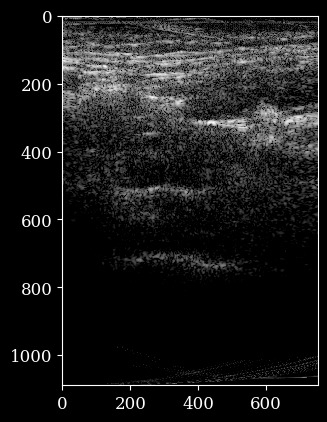

In [7]:
# now let's use the pipeline with the same operations but with the classes directly
# instead of using the config file / dictionary

pipeline = Pipeline(
    operations = [
        Demodulate(),
        PatchedGrid(
            operations = [
                TOFCorrection(),
                PfieldWeighting(),
                DelayAndSum()
            ],
            num_patches = 100
        ),
        EnvelopeDetect(),
        Normalize(),
        LogCompress(),
    ],
    with_batch_dim = False,
    jit_options = "pipeline",
)

outputs = pipeline(**inputs, **parameters, dynamic_range=(-50, 0))

image = outputs[pipeline.output_key]

image_display = to_8bit(image, config.data.dynamic_range)

plt.figure()
plt.imshow(image_display, cmap="gray")

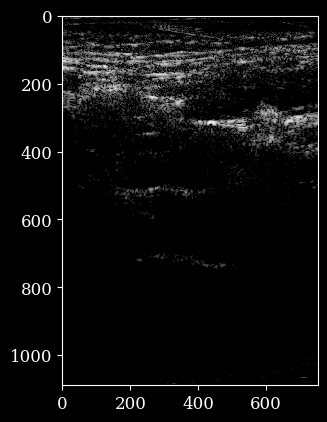

In [8]:
# changing some parameters on the fly with compile pipeline
# should be also really fast as pipeline was already compiled
dynamic_range = (-30, 0)

outputs = pipeline(**inputs, **parameters, dynamic_range=dynamic_range)

image = outputs[pipeline.output_key]

image_display = to_8bit(image, dynamic_range)

plt.figure()
plt.imshow(image_display, cmap="gray")

usbmd: Running compute_pfield and caching the result to /home/devcontainer0/.usbmd_cache/compute_pfield_aee4da0937b789402d28951fcb5113e5.pkl.
usbmd: Computing pressure field for all transmits
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 706ms/transmits


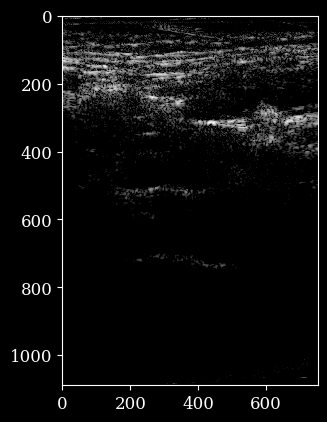

In [9]:
# Let's see how to change the number of transmits for reconstruction

# set selected_transmits such that internal parameters are updated
scan.selected_transmits = 11
# now we need to prepare the parameters again as internal scan parameters have changed
parameters = pipeline.prepare_parameters(probe, scan, config)

data_11_transmits = data[0][scan.selected_transmits]

inputs = {pipeline.key: data_11_transmits}

outputs = pipeline(**inputs, **parameters)

image = outputs[pipeline.output_key]

image_display = to_8bit(image, dynamic_range)

plt.figure()
plt.imshow(image_display, cmap="gray")